In [2]:
import os
import pandas as pd
import torch

from learning_models.sidarthe import Sidarthe
from learning_models.tied_sidarthe_extended import TiedSidartheExtended
from populations import populations

from utils.data_utils import select_data
from utils.visualization_utils import generic_plot, Curve, generic_sub_plot, Plot, generate_format_xtick

from torch_euler import Heun
import json

import seaborn as sns
import datetime

from matplotlib import pyplot as plt
import matplotlib

from utils.visualization_utils import parse_date

In [3]:
# load targets

# load targets
df_file = os.path.join(os.getcwd(), "data", "COVID-19", "dati-andamento-nazionale", "dpc-covid19-ita-andamento-nazionale.csv")
area = ["ITA"]
area_col_name = "stato"  # "Country/Region"

groupby_cols = ["data"]  # ["Date"]

d_col_name = "isolamento_domiciliare"
r_col_name = "ricoverati_con_sintomi"
t_col_name = "terapia_intensiva"
h_detected_col_name = "dimessi_guariti"
e_col_name = "deceduti"  # "Fatalities"

x_target, d_target, dates = select_data(df_file, area, area_col_name, d_col_name, groupby_cols, file_sep=",")
_, y_target, _ = select_data(df_file, area, area_col_name, "totale_positivi", groupby_cols, file_sep=",")
_, r_target, _ = select_data(df_file, area, area_col_name, r_col_name, groupby_cols, file_sep=",")
_, t_target, _ = select_data(df_file, area, area_col_name, t_col_name, groupby_cols, file_sep=",")
_, h_detected_target, _ = select_data(df_file, area, area_col_name, h_detected_col_name, groupby_cols, file_sep=",")
_, e_target, _ = select_data(df_file, area, area_col_name, e_col_name, groupby_cols, file_sep=",")

initial_len = len(y_target)
tmp_d, tmp_r, tmp_t, tmp_h, tmp_e = [], [], [], [], []
for i in range(initial_len):
    if y_target[i] > 0:
        tmp_d.append(d_target[i])
        tmp_r.append(r_target[i])
        tmp_t.append(t_target[i])
        tmp_h.append(h_detected_target[i])
        tmp_e.append(e_target[i])
d_target = tmp_d
r_target = tmp_r
t_target = tmp_t
h_detected_target = tmp_h
e_target = tmp_e

targets = {
    "d": d_target,
    "r": r_target,
    "t": t_target,
    "h_detected": h_detected_target,
    "e": e_target
}

In [4]:
# load references
references = {}
param_keys = ['alpha', 'beta', 'gamma', 'delta', 'epsilon', 'theta', 'xi', 'eta', 'mu', 'nu', 'tau', 'lambda', 'kappa', 'zeta', 'rho', 'sigma']
ref_df = pd.read_csv(os.path.join(os.getcwd(), "data", "sidarthe_results_new.csv"))
#ref2_df = pd.read_csv(os.path.join(os.getcwd(), "regioni", "sidarthe_results_2.csv"))


for key in 'sidarthe':
    references[key] = ref_df[key][4:].tolist()

for key in ["h_detected"]:
    references[key] = ref_df[key][4:].tolist()

for key in ["r0"]:
    references[key] = ref_df[key][4:].tolist()

for key in param_keys:
    references[key] = ref_df[key][4:].tolist()


In [5]:
# load experiment values
exp_paths = os.path.join(os.getcwd(), "runs", "paper_models", "IT")
exp_id = "598e1f1f-e209-4014-9ea2-580a1623b5ff"
exp_path = os.path.join(exp_paths, exp_id)
exp_settings_path = os.path.join(exp_path, "settings.json")
exp_report_path = os.path.join(exp_path, "final.json")

with open(exp_settings_path) as settings_json:
    exp_settings = json.load(settings_json)

with open(exp_report_path) as report_json:
    exp_report = json.load(report_json)

In [6]:
# create trained model
population = populations["Italy"]
integrator = Heun
time_step = 1.

params = exp_report["params"]
train_size = exp_settings["train_size"]
val_size = exp_settings["val_len"]
dataset_size = len(x_target)

model_params = { 
    "d_weight": 1.,
    "r_weight": 1.,
    "t_weight": 1.,
    "h_weight": 1.,
    "e_weight": 1.,
    "der_1st_reg": 0.,
    "bound_reg": 0.,
    "verbose": False,
    "loss_type": "rmse",
    "references": references,
    "targets": targets,
    "train_size": train_size,
    "val_size": val_size,
    "first_date": dates[0]
}
init_conditions_params = { "population": population }
initial_conditions = Sidarthe.compute_initial_conditions_from_targets(targets, init_conditions_params)

model = TiedSidartheExtended(params, population, initial_conditions, integrator, time_step, **model_params)

{'d': 4.087547896826247, 'r': 17.518783575513645, 't': 157.37376922254086, 'h': 1.0, 'e': 4.931346214284586}


In [7]:
# compute inference
with torch.no_grad():
    t_start = 0
    t_end = train_size

    t_grid = torch.linspace(0, dataset_size, int(dataset_size / time_step) + 1)
    inferences = model.inference(t_grid)

In [8]:
# slice dataset
train_hat_slice = slice(t_start, int(train_size / time_step), int(1 / time_step))
val_hat_slice = slice(int(train_size / time_step), int(train_size + val_size / time_step),int(1 / time_step))
test_hat_slice = slice(int(train_size + val_size / time_step), int(dataset_size / time_step), int(1 / time_step))
dataset_hat_slice = slice(t_start, int(dataset_size / time_step), int(1 / time_step))

train_target_slice = slice(t_start, train_size, 1)
val_target_slice = slice(train_size, train_size + val_size, 1)
test_target_slice = slice(train_size + val_size, dataset_size, 1)
dataset_target_slice = slice(t_start, dataset_size, 1)

def slice_values(values, slice_):
    return {key: value[slice_] for key, value in values.items()}

hat_train = slice_values(inferences, train_hat_slice)
hat_val = slice_values(inferences, val_hat_slice)
hat_test = slice_values(inferences, test_hat_slice)
hat_dataset = slice_values(inferences, dataset_hat_slice)

target_train = slice_values(targets, train_target_slice)
target_val = slice_values(targets, val_target_slice)
target_test = slice_values(targets, test_target_slice)
target_dataset = slice_values(targets, dataset_target_slice)


references = { k: torch.tensor(v, dtype=model.dtype) for k,v in references.items() }

references_train = slice_values(references, train_target_slice)
references_val = slice_values(references, val_target_slice)
references_test = slice_values(references, test_target_slice)
references_dataset = slice_values(references, dataset_target_slice)

normalized_references = model.normalize_values(targets, 1./model.population)
norm_references_train = slice_values(normalized_references, train_hat_slice)
norm_references_val = slice_values(normalized_references, val_hat_slice)
norm_references_test = slice_values(normalized_references, test_hat_slice)



In [9]:
# define utility funcs
def extend_param(value, length):
    len_diff = length - value.shape[0]
    if len_diff > 0:
        return torch.cat((value, value[-1].expand(len_diff)))
    else:
        return value

import numpy as np

train_slice = slice(0, train_size)
val_slice = slice(train_size, train_size + val_size)
test_slice = slice(train_size + val_size, dataset_size)

slices = {
    "train": train_slice,
    "val": val_slice,
    "test": test_slice
}

dataset_slice = slice(0, dataset_size)

test_size = dataset_size - train_size - val_size

def get_column(values, col_slice):

    column = [None] * col_slice.start + values + [None] * (dataset_size - col_slice.stop)
    return column


In [10]:
figs_path = os.path.join(exp_path, "figs")
if not os.path.exists(figs_path):
    os.makedirs(figs_path)

def savefig(figure, figures_path, figure_name):
    fig_path = os.path.join(figures_path, f"{figure_name}.pdf")
    figure.savefig(fig_path, bbox_inches='tight', transparent=False)

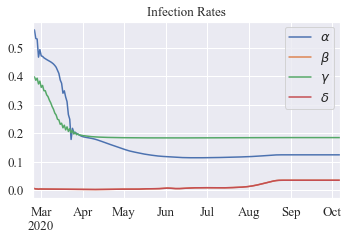

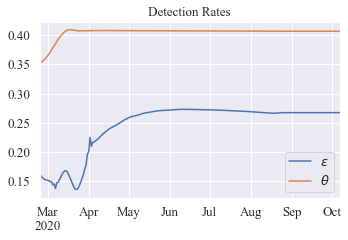

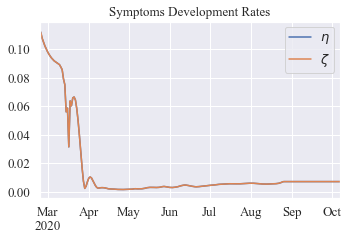

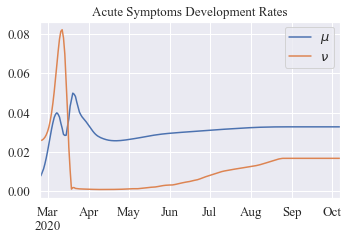

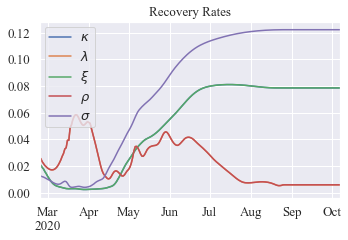

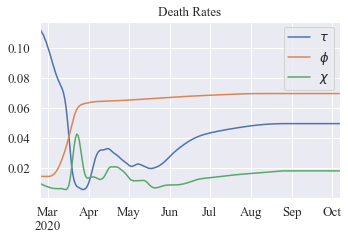

In [11]:
group_dfs = {}
params = model.params
start_date = parse_date(dates[0])
dates_x = [(start_date + datetime.timedelta(int(n))).strftime("%Y-%m-%d") for n in range(0, dataset_size)]
#del matplotlib.font_manager.weight_dict['roman']
sns.set(font="Times New Roman")

font_size = '13'

for group_name, group in model.param_groups.items():
    group_df = pd.DataFrame()
    group_df['date'] = pd.to_datetime(dates_x)
    group_df.set_index('date', inplace=True)
    #group_df['test'] = [i for i in range(0, len(dates_x))]
    for param_name in group:
        group_df[f"$\{param_name}$"] = extend_param(params[param_name], dataset_size).detach().numpy()

    plot_title = group_name.replace("_", " ").title()
    plot = group_df.plot(title=plot_title, figsize=(5,3.5), fontsize=font_size)
    plot.title.set_fontsize(font_size)
    plt.setp(plot.get_legend().get_texts(), fontsize=font_size)
    plot.axes.xaxis.label.set_visible(False)
    
    figure = plot.get_figure()
    figure.set_tight_layout(True)
    savefig(figure, figs_path, group_name)

    #group_dfs[group_name] = group_df

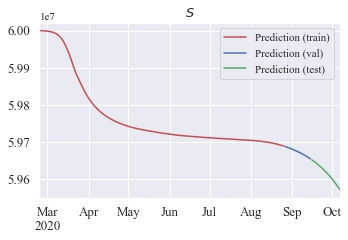

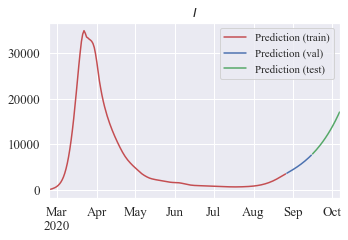

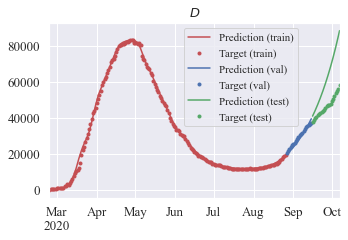

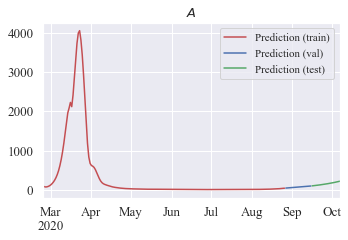

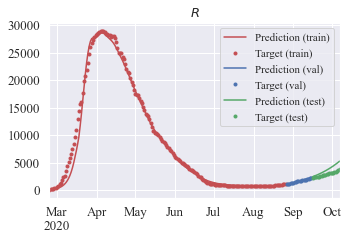

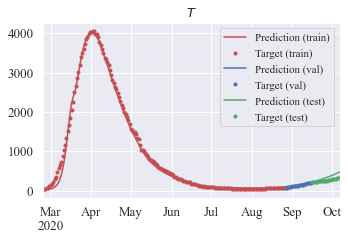

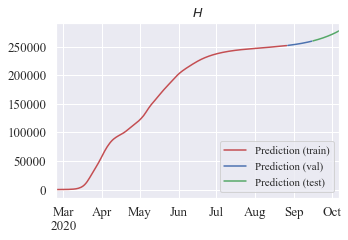

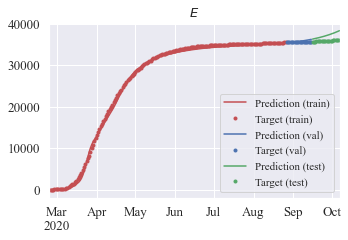

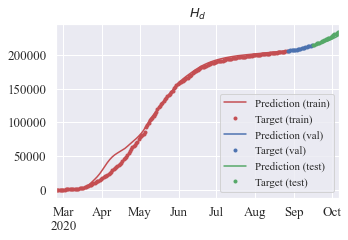

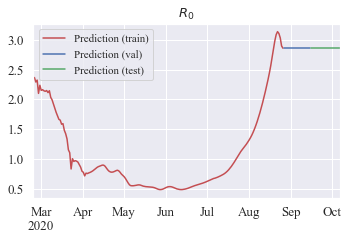

In [12]:
for key in ["s", "i", "d", "a", "r", "t", "h", "e", "h_detected", "r0"]:
#for key in ["d"]:

    if key == "h_detected":
        plot_title = "$H_d$"
    elif key == "r0":
        plot_title = "$R_0$"
    else:
        plot_title = f"${key.upper()}$"
        
    hats = {
        "train": hat_train[key].numpy().tolist(),
        "val": hat_val[key].numpy().tolist(),
        "test": hat_test[key].numpy().tolist()
    }

    if key in targets:
        c_targets = {
            "train": target_train[key],
            "val": target_val[key],
            "test": target_test[key]
        }
    else:
        c_targets = {
            "train": None,
            "val": None,
            "test": None
        }

    curve_df = pd.DataFrame()
    curve_df['date'] = pd.to_datetime(dates_x[:])
    curve_df.set_index('date', inplace=True)


    for section, section_slice in slices.items():
        curve_df[f"Prediction ({section})"] = get_column(hats[section], section_slice)
        if c_targets[section] is not None: 
            curve_df[f"Target ({section})"] = get_column(c_targets[section], section_slice)
            curve_styles = ['-', '.'] * 3
            curve_colors = ['r'] * 2 + ['b'] * 2 + ['g'] * 2
        else:
            curve_styles = ['-'] * 3
            curve_colors = ['r', 'b', 'g']


    plot = curve_df.plot(title=plot_title, style=curve_styles, color=curve_colors, figsize=(5,3.5), grid=True, fontsize=font_size)
    plot.title.set_fontsize(font_size)
    plt.setp(plot.get_legend().get_texts(), fontsize=font_size)

    if key != 'd':
        plt.legend(loc='best')
    else:
        plt.legend(loc='upper center', bbox_to_anchor=(0.66,1.))
    #plt.setp(plot.texts, fontsize='1')
    plot.axes.xaxis.label.set_visible(False)
    
    figure = plot.get_figure()
    figure.set_tight_layout(True)

    savefig(figure, figs_path, key)